# TGS Salt Identification Challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Make plots display well on retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pdb

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from fastai.models.senet import *

In [5]:
torch.cuda.set_device(0)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from pathlib import Path

PATH = Path('data/')
list(PATH.iterdir())

[PosixPath('data/depths.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_images'),
 PosixPath('data/models'),
 PosixPath('data/train_masks'),
 PosixPath('data/train.csv'),
 PosixPath('data/test_images'),
 PosixPath('data/tmp')]

In [8]:
DEPTHS_FN = 'depths.csv'
TRAIN_FN = 'train.csv'
TRAIN_IMS = 'train_images'
TRAIN_MSKS = 'train_masks'
TEST_IMS = 'test_images'
MODELS = 'models'

In [9]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

70db04a203.png


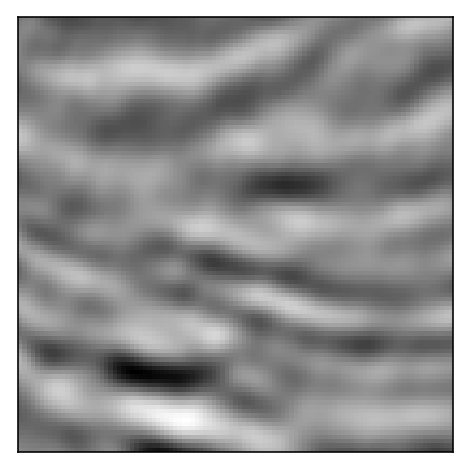

In [10]:
# Show a train image with salt
img = open_image(PATH/TRAIN_IMS/'70db04a203.png')
print('70db04a203.png')
show_img(img);

In [11]:
# Here's what the above image's raw data looks like
img.shape

(101, 101, 3)

In [12]:
img[:4,:4]

array([[[0.47059, 0.47059, 0.47059],
        [0.49412, 0.49412, 0.49412],
        [0.50196, 0.50196, 0.50196],
        [0.49412, 0.49412, 0.49412]],

       [[0.49804, 0.49804, 0.49804],
        [0.51373, 0.51373, 0.51373],
        [0.52157, 0.52157, 0.52157],
        [0.5098 , 0.5098 , 0.5098 ]],

       [[0.51373, 0.51373, 0.51373],
        [0.52549, 0.52549, 0.52549],
        [0.52941, 0.52941, 0.52941],
        [0.5098 , 0.5098 , 0.5098 ]],

       [[0.52157, 0.52157, 0.52157],
        [0.52549, 0.52549, 0.52549],
        [0.51373, 0.51373, 0.51373],
        [0.49804, 0.49804, 0.49804]]], dtype=float32)

70db04a203.png


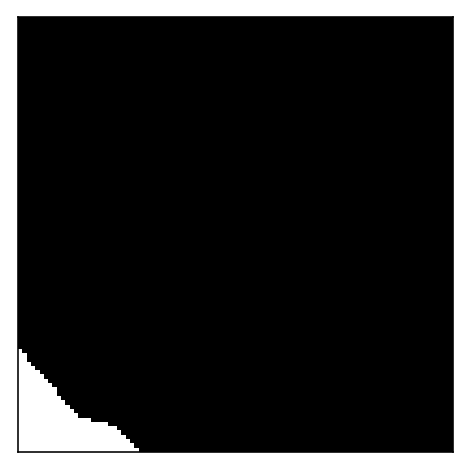

In [13]:
# Show an example of the corresponding mask from the training set
img_mask = open_image(PATH/TRAIN_MSKS/'70db04a203.png')
print('70db04a203.png')
show_img(img_mask);

In the mask above, the white pixels (with values of 1.0) indicate the presence of salt. Black pixels (with values of 0.0) indicate an absence of salt. These masks essentially serve as the training labels for each image in the training image set.

In [14]:
# Here's what the above mask image's raw data looks like
img_mask.shape

(101, 101, 3)

In [15]:
display(np.array2string(img_mask[-1][:,0]).replace('\n', ''))

'[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]'

Observe that the distribution of 1 and 0 values in the last row of the mask's array corresponds to the order of white and black pixels in the bottom row of the actual mask image above. The first roughly 1/3rd of the values are 1 (white), and the final 2/3rds are 0 (black).

In [16]:
# Plot several images chosen at random, overlaid with their masks
np.random.seed(42)
ids = list(pd.read_csv(PATH/TRAIN_FN)['id'].sample(16))

In [17]:
ims = [open_image(PATH/TRAIN_IMS/f'{ids[i]}.png') for i in range(16)]
im_masks = [open_image(PATH/TRAIN_MSKS/f'{ids[i]}.png') for i in range(16)]

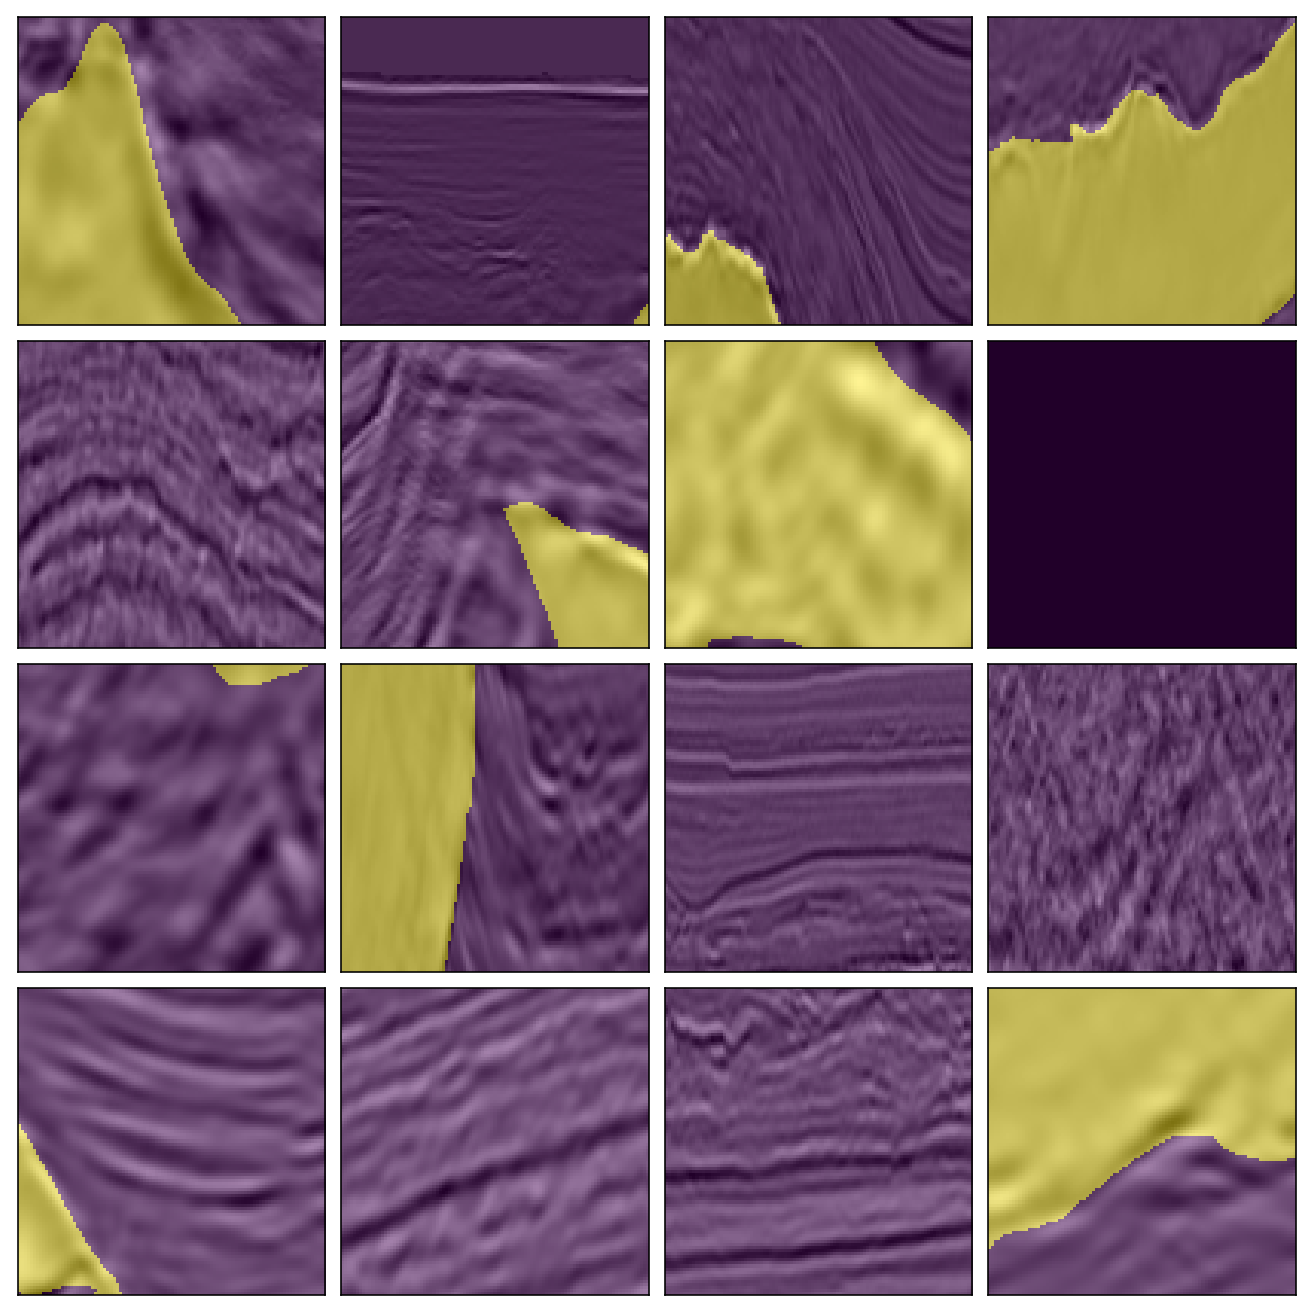

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

Yellow highlights indicate salt.

In [19]:
# Let's take a look at a sample of the train.csv file
train_df = pd.read_csv(PATH/TRAIN_FN, index_col="id")
display(train_df.head(n=10))

,rle_mask
id,
575d24d81d,NaN
a266a2a9df,5051 5151
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
9842f69f8d,NaN
aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
50d3073821,1 2121 9293 909


In [20]:
# And here is what depths.csv looks like
depths_df = pd.read_csv(PATH/DEPTHS_FN, index_col="id")
display(depths_df.head(n=10))

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783
2ffea0c397,429
6cf284fb9e,600
d0244d6c38,51
cffbfab33b,755


In [21]:
# Join depth information to the train dataframe. Also 
# create a similar dataframe for test ids that contains 
# corresponding depths
train_df.drop('rle_mask', axis=1, inplace=True)
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [22]:
display(test_df.head())

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [23]:
display(train_df.head())

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [24]:
len(train_df)

4000

In [25]:
len(test_df)

18000

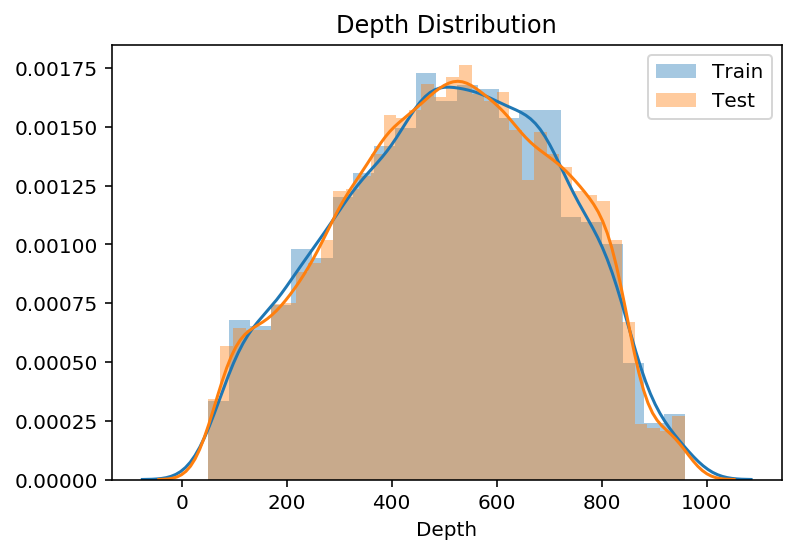

In [26]:
sns.distplot(train_df['z'], label="Train")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Depth Distribution");

In [27]:
# create depths class for stratification
train_df['z_class'] = pd.cut(train_df['z'], 8, labels=[1,2,3,4,5,6,7,8])

In [28]:
display(train_df.head())

,z,z_class
id,,
575d24d81d,843,7
a266a2a9df,794,7
75efad62c1,468,4
34e51dba6a,727,6
4875705fb0,797,7


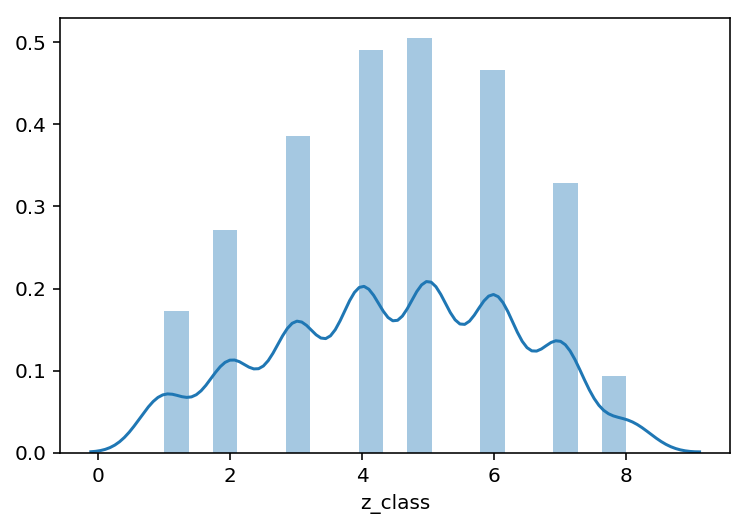

In [29]:
sns.distplot(train_df['z_class'], label="Train");

In [30]:
# create coverage class
train_df['masks'] = [np.array(open_image(PATH/TRAIN_MSKS/f'{i}.png')) for i in list(train_df.index)]

In [31]:
train_df['cov'] = train_df['masks'].map(lambda x: np.sum(x)/3)

In [32]:
train_df.drop('masks', axis=1, inplace=True)

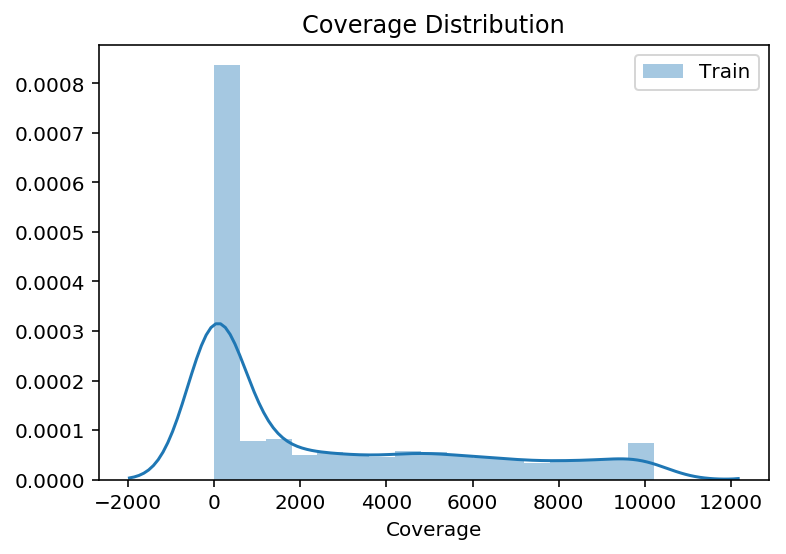

In [33]:
sns.distplot(train_df['cov'], label="Train")
plt.legend()
plt.xlabel('Coverage')
plt.title('Coverage Distribution');

In [34]:
train_df['cov_class'] = pd.cut(train_df['cov'], 8, labels=[1,2,3,4,5,6,7,8])

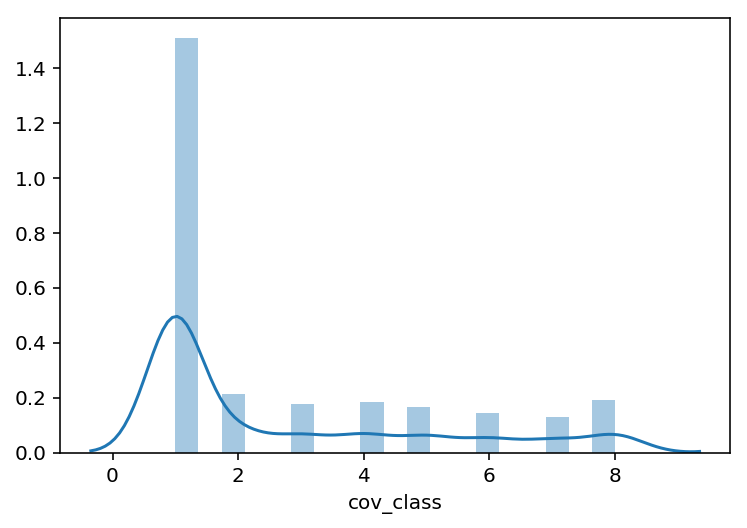

In [35]:
sns.distplot(train_df['cov_class'], label='Train');

In [36]:
train_df['im_path'] = train_df.index.map(lambda x: Path(TRAIN_IMS)/f'{x}.png')
                                         

In [37]:
train_df['msk_path'] = train_df.index.map(lambda x: Path(TRAIN_MSKS)/f'{x}.png')


In [38]:
display(train_df.head())

,z,z_class,cov,cov_class,im_path,msk_path
id,,,,,,
575d24d81d,843,7,0.0,1,train_images/575d24d81d.png,train_masks/575d24d81d.png
a266a2a9df,794,7,5151.0,5,train_images/a266a2a9df.png,train_masks/a266a2a9df.png
75efad62c1,468,4,10133.0,8,train_images/75efad62c1.png,train_masks/75efad62c1.png
34e51dba6a,727,6,1522.0,2,train_images/34e51dba6a.png,train_masks/34e51dba6a.png
4875705fb0,797,7,437.0,1,train_images/4875705fb0.png,train_masks/4875705fb0.png


### Split Validation off from Train Set

In [39]:
train, val = train_test_split(train_df, test_size=0.2, stratify=train_df['z_class'])

In [40]:
len(train)

3200

In [41]:
len(val)

800

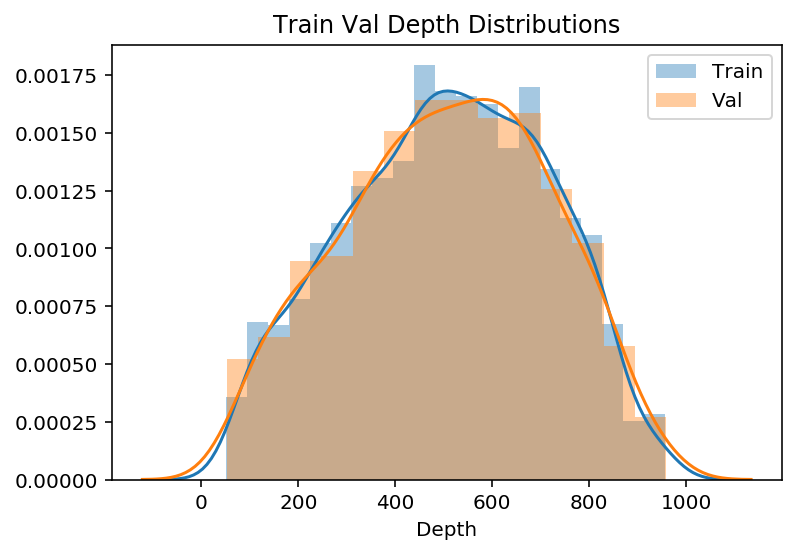

In [42]:
sns.distplot(train['z'], label="Train")
sns.distplot(val['z'], label="Val")
plt.legend()
plt.xlabel('Depth')
plt.title("Train Val Depth Distributions");

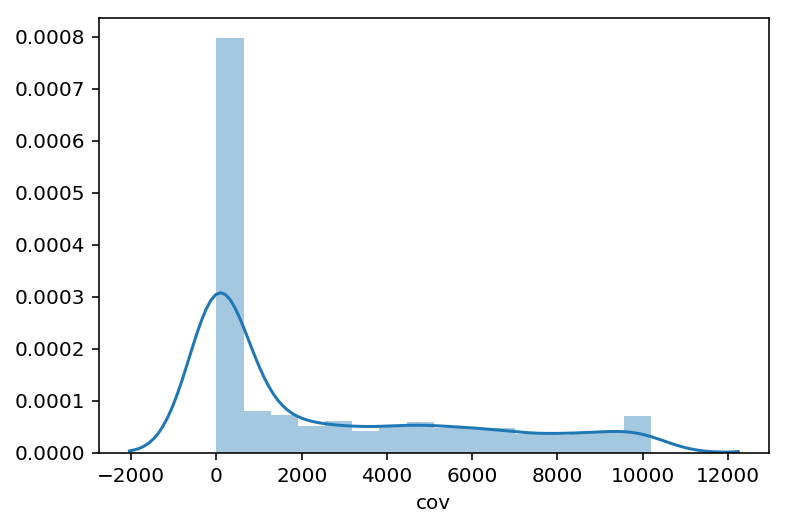

In [43]:
sns.distplot(train['cov'], label="Train");

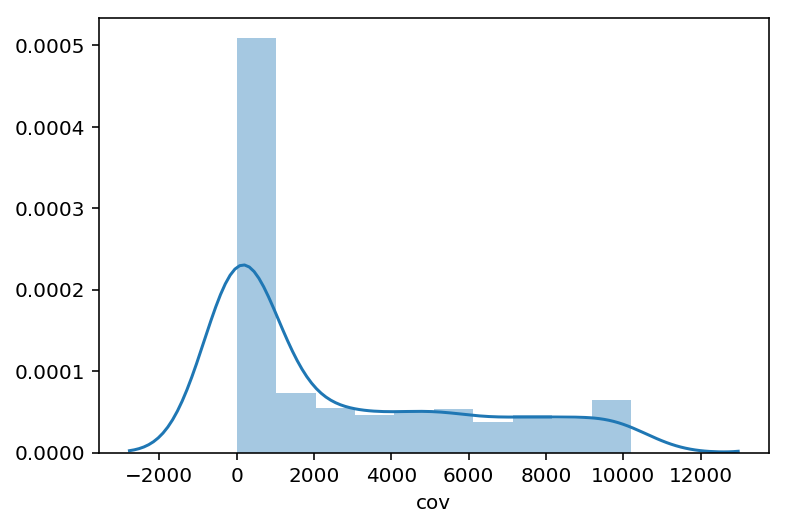

In [44]:
sns.distplot(val['cov'], label="Val");

## Dataset

In [45]:
trn_x = np.array(train['im_path'])
val_x = np.array(val['im_path'])
trn_y = np.array(train['msk_path'])
val_y = np.array(val['msk_path'])

In [46]:
test_df['im_path'] = test_df.index.map(lambda x: Path(TEST_IMS)/f'{x}.png')

In [47]:
tst_x = np.array(test_df['im_path'])

In [48]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [49]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [50]:
arch = resnet34
sz=128
bs = 6

In [51]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)

In [52]:
def get_augs():
    denorm = md.trn_ds.denorm
    x,y = next(iter(md.aug_dl))
    x = denorm(x)
    return x, y

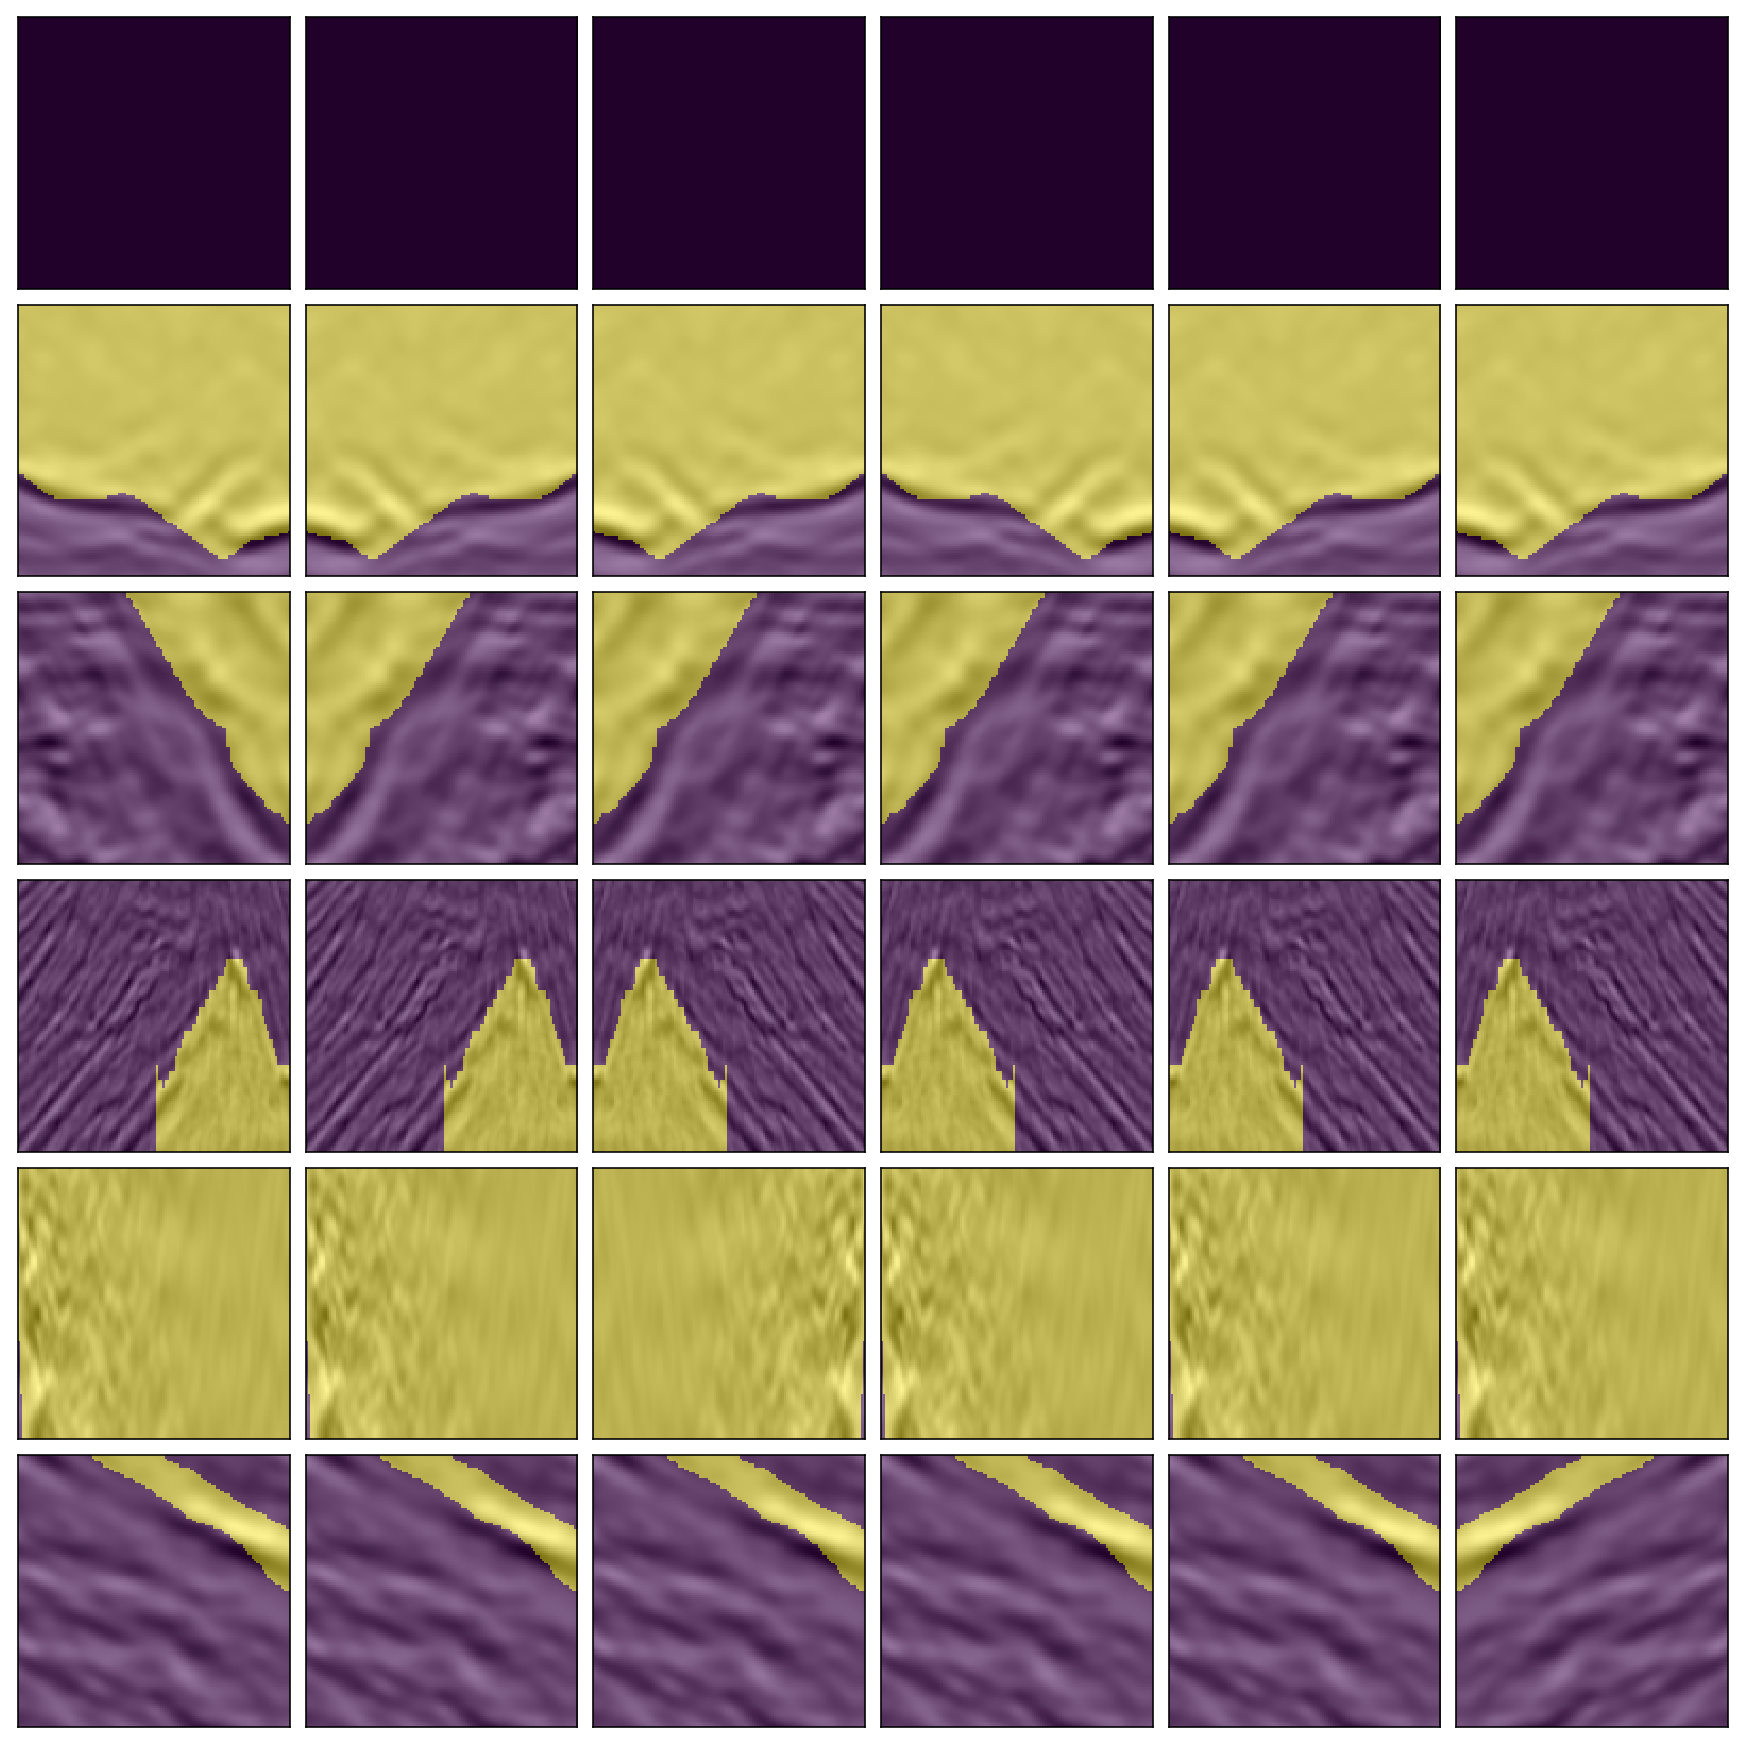

In [53]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
for row in axes.T:
    x, y = get_augs()
    for i, ax in enumerate(row):
        ax=show_img(x[i%6], ax=ax)
        show_img(y[i%6].cpu(), ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## U-Net with SE-RexNeXt Backbone

In [54]:
MODEL_NAME = 'unet_se_resnext50'

In [55]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [56]:
# Concurrent Spatial and Channel Squeeze & Excitation
# From https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66178

class CSE(nn.Module):
    def __init__(self, in_ch, r):
        super(CSE, self).__init__()
        self.linear_1 = nn.Linear(in_ch, in_ch//r)
        self.linear_2 = nn.Linear(in_ch//r, in_ch)

    def forward(self, x):
        input_x = x
        x = x.view(*(x.shape[:-2]),-1).mean(-1)
        x = F.relu(self.linear_1(x), inplace=True)
        x = self.linear_2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.sigmoid(x)
        x = input_x * x
        return x
    
class SSE(nn.Module):
    def __init__(self, in_ch):
        super(SSE, self).__init__()
        self.conv = nn.Conv2d(in_ch, 1, kernel_size=1, stride=1)

    def forward(self, x):
        input_x = x
        x = self.conv(x)
        x = torch.sigmoid(x)
        x = input_x * x
        return x

class SCSE(nn.Module):
    def __init__(self, in_ch, r):
        super(SCSE, self).__init__()
        self.cSE = CSE(in_ch, r)
        self.sSE = SSE(in_ch)

    def forward(self, x):
        cSE = self.cSE(x)
        sSE = self.sSE(x)
        x = cSE + sSE
        return x

In [57]:
# class UnetBlock(nn.Module):
#     def __init__(self, up_in, x_in, n_out):
#         super().__init__()
#         up_out = x_out = n_out//2
#         self.x_conv = nn.Conv2d(x_in, x_out, 1)
#         self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
#         self.bn = nn.BatchNorm2d(n_out)
#         self.scse = SCSE(n_out, 16)
        
#     def forward(self, up_p, x_p):
# #         print(up_p.size()) # torch.Size([8, 2048, 2, 2])
# #         print(x_p.size()) # torch.Size([8, 2048, 2, 2])
#         up_p = self.tr_conv(up_p)
#         x_p = self.x_conv(x_p)
# #         print(up_p.size()) # torch.Size([8, 512, 4, 4])
# #         print(x_p.size()) # torch.Size([8, 512, 2, 2])
#         cat_p = torch.cat([up_p,x_p], dim=1)
#         return self.scse(self.bn(F.relu(cat_p)))

In [58]:
class UnetBlock(nn.Module):
    def __init__(self, up_in_c, x_in_c):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(up_in_c, up_in_c // 2, 2, 2) # H, W -> 2H, 2W
        self.conv1 = nn.Conv2d(x_in_c + up_in_c // 2, (x_in_c + up_in_c // 2) // 2, 3, 1, 1)
        self.conv2 = nn.Conv2d((x_in_c + up_in_c // 2) // 2, (x_in_c + up_in_c // 2) // 2, 3, 1, 1)
        self.bn = nn.BatchNorm2d((x_in_c + up_in_c // 2) // 2)
        self.scse = SCSE((x_in_c + up_in_c // 2) // 2, 16)
        
    def forward(self, up_in, x_in):
        up_out = self.upconv(up_in)
#         print(up_in.size()) # 
#         print(x_in.size()) # 
#         print(up_out.size()) # 
        cat_x = torch.cat([up_out, x_in], dim=1)
        x = F.relu(self.conv1(cat_x))
        x = F.relu(self.conv2(x))
        return self.scse(self.bn(x))

In [59]:
class UnetSEResNext50(nn.Module):
    def __init__(self, seRNxt50):
        super().__init__()
        self.seRNxt50 = seRNxt50
        self.sfs = [SaveFeatures(seRNxt50[i]) for i in [0,1, 2, 3]]
        self.up1 = UnetBlock(2048,1024)
        self.up2 = UnetBlock(1024,512)
        self.up3 = UnetBlock(512,256)
        self.up4 = UnetBlock(256,64)
        self.up5 = nn.ConvTranspose2d(96,1,2,stride=2)

    def forward(self,x):
        x = F.relu(self.seRNxt50(x))
#         print(x.size()) # torch.Size([8, 2048, 2, 2])
#         print(self.sfs[4].features.size()) # torch.Size([8, 2048, 2, 2])
#         print(self.sfs[3].features.size()) # torch.Size([8, 1024, 4, 4])
#         print(self.sfs[2].features.size()) # torch.Size([8, 512, 8, 8])
#         print(self.sfs[1].features.size()) # torch.Size([8, 256, 16, 16])
#         print(self.sfs[0].features.size()) # torch.Size([8, 64, 16, 16])
        d1 = self.up1(x, self.sfs[3].features)
        d2 = self.up2(d1, self.sfs[2].features)
        d3 = self.up3(d2, self.sfs[1].features)
#         print(d1.size()) # torch.Size([8, 1024, 4, 4])
#         print(d2.size()) # torch.Size([8, 512, 8, 8])
#         print(d3.size()) # torch.Size([8, 256, 16, 16])
#         print(F.upsample(self.sfs[0].features, scale_factor=2, mode='bilinear').size()) # torch.Size([8, 64, 32, 32])
        d4 = self.up4(d3, F.interpolate(self.sfs[0].features, scale_factor=2, mode='bilinear',align_corners=True))
        d5 = self.up5(d4)
#         print(d4.size()) # torch.Size([8, 1, 32, 32])
        return d5[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            


In [60]:
class UnetModel():
    def __init__(self, model, name=MODEL_NAME):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.seRNxt50), [lr_cut]))
        return lgs + [children(self.model)[1:]]

### Lovasz Loss

In [61]:
# Calculating Lovasz Hinge Loss
# https://arxiv.org/abs/1705.08790
# https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [62]:
def lovasz_loss(logits, labels):
    labels, logits = labels.squeeze(1), logits.squeeze(1)
    labels = torch.Tensor(labels.data.cpu().numpy()).cuda()
    loss = lovasz_hinge(logits, labels, per_image = True, ignore = None)
    return loss

### Competition Metric (IOU)

In [63]:
# The evaluation metric: mean average precision at 
# different intersection over union (IoU) thresholds.

# Inspired by Kerem Turgutlu:
# https://github.com/KeremTurgutlu/airbus/blob/master/eval_metric.py

def IOU(pred, targ):
    smooth = 1e-6
    intersection = np.sum(pred * targ)
    union = np.sum((pred + targ) > 0)
    return (intersection + smooth) / (union + smooth)

def avg_precision_IOU(pred, targ):
    IOU_score = IOU(pred, targ)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        prec.append((IOU_score > t).astype('uint8'))
    return np.mean(prec)

def mean_avg_precision_IOU(preds, targs, thresh=0.0):
    scores = []
    preds = (to_np(preds) > thresh).astype('uint8')
    targs = to_np(targs)
    for i, (pred_i, targ_i) in enumerate(zip(preds, targs)):
        pred_i, targ_i = scale_min(pred_i, 101), scale_min(targ_i, 101)
        scores.append(avg_precision_IOU(pred_i, targ_i))
    return np.mean(scores)

## Single Fold CV Split

### Progressive resizing with use_clr

In [64]:
ARCH = se_resnext50_32x4d()
cut = -2 # where to cut the head of the model (which will be replaced with a custom head)
lr_cut = 2 # where to split the rest of the model into middle and tail groups

### 64x64

In [71]:
sz=64
bs=80
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = nn.Sequential(*list(children(ARCH))[:cut])
m = to_gpu(UnetSEResNext50(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]
learn.crit=lovasz_loss
learn.freeze_to(1)


epoch      trn_loss   val_loss   mean_avg_precision_IOU   
    0      7.063874   4.155085614719175e+22 0.033875  



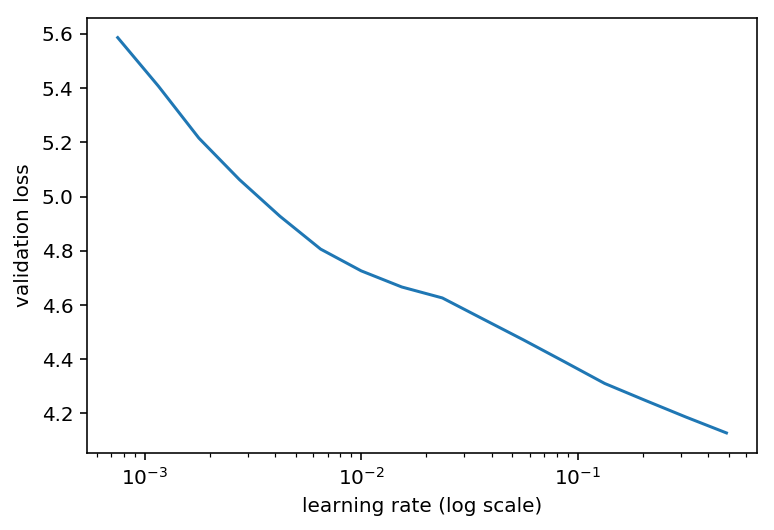

In [80]:
learn.lr_find()
learn.sched.plot()

In [68]:
sz=64
bs=80
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = nn.Sequential(*list(children(ARCH))[:cut])
m = to_gpu(UnetSEResNext50(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp0')
learn.load('64-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp1')
learn.load('64-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp2')
learn.load('64-tmp2')
learn.crit=lovasz_loss
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='64')

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.294532   1.581785   0.35075   
    1      0.228445   0.194043   0.650125                  
    2      0.190955   0.167325   0.6715                    
    3      0.164484   0.14706    0.684875                  
    4      0.141141   0.142464   0.691                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.630963   0.705932   0.620875  
    1      0.549102   0.579946   0.659375                  
    2      0.492383   0.507102   0.68825                   
    3      0.458535   0.481201   0.71075                   
    4      0.425944   0.454181   0.71675                   



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.200025   0.368061   0.648875  
    1      0.173192   0.161358   0.68775                   
    2      0.160695   0.168985   0.695                     
    3      0.149108   0.168692   0.685875                  
    4      0.134623   0.139871   0.711875                  
    5      0.121994   0.160082   0.691                     
    6      0.105858   0.136922   0.72075                   
    7      0.097235   0.138681   0.72925                    
    8      0.085166   0.137414   0.733                      
    9      0.076386   0.15822    0.73325                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.401001   0.511128   0.716125  
    1      0.376793   335.466075 0.7225                    
    2      0.360925   0.450495   0.722375                  
    3      0.375341   0.534883   0.68975                   
    4      0.380931   0.482299   0.70775                   
    5      0.366199   0.434153   0.735875                  
    6      0.348639   0.463186   0.72175                   
    7      0.348423   0.454806   0.72375                   
    8      0.339028   0.448018   0.724                     
    9      0.325603   0.440637   0.727375                  
    10     0.327249   0.398324   0.753875                  
    11     0.315733   0.407904   0.741875                  
    12     0.299505   0.404959   0.751625                  
    13     0.284951   0.398092   0.75125                   
    14     0.284256   0.421926   0.739                     
    15     0.271602   0.397257   0.755125               

[0.3890100300312042, 0.7525]

### 128x128

In [68]:
sz=128
bs=50
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = nn.Sequential(*list(children(ARCH))[:cut])
m = to_gpu(UnetSEResNext50(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.load('64')
learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp0')
learn.load('128-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp1')
learn.load('128-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp2')
learn.load('128-tmp2')
learn.crit=lovasz_loss
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs/2,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='128')

epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.19132    0.157235   0.67925   
    1      0.159866   0.148437   0.70475                   
    2      0.149581   0.143233   0.718625                  
    3      0.145251   0.14746    0.7205                    
    4      0.121291   0.123839   0.73725                   



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.434732   0.471531   0.72875   
    1      0.441969   0.532903   0.7075                    
    2      0.413839   0.456005   0.740625                  
    3      0.379211   0.417961   0.745125                  
    4      0.358448   0.409767   0.75125                   



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.171663   0.264216   0.631875  
    1      0.14956    0.153687   0.712875                  
    2      0.133918   0.129861   0.739125                  
    3      0.122304   0.134296   0.742375                  
    4      0.110087   0.130794   0.75025                   
    5      0.101449   0.125589   0.75925                    
    6      0.090092   0.129922   0.736625                   
    7      0.088692   0.158869   0.7475                     
    8      0.078789   0.24417    0.75325                    
    9      0.065729   0.122033   0.7605                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU    
    0      0.33341    0.417717   0.77025   
    1      0.289756   0.398357   0.77425                   
    2      0.282558   0.388562   0.77125                   
    3      0.273712   0.376075   0.77125                   
    4      0.259342   1.369142   0.774125                  
    5      0.257642   0.384136   0.7695                    
    6      0.26553    0.381771   0.768125                  
    7      0.243761   0.36614    0.7815                    
    8      0.236528   0.375073   0.772375                  
    9      0.234042   0.407023   0.770125                  
    10     0.235526   0.90042    0.75875                   
    11     0.223434   0.384592   0.76825                   
    12     0.218962   0.365194   0.775625                  
    13     0.229111   0.364447   0.772125                  
    14     0.216807   0.356936   0.774125                  
    15     0.204515   0.367002   0.77175                

[0.3565333615988493, 0.7777499999999999]

### 256x256 All but final round

In [65]:
sz=256
bs=20
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
wd=1e-2
lrs = np.array([lr/9,lr/3,lr])

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = nn.Sequential(*list(children(ARCH))[:cut])
m = to_gpu(UnetSEResNext50(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

learn.load('128')
learn.crit=nn.BCEWithLogitsLoss()
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp0')
learn.load('256-tmp0')
learn.crit=lovasz_loss
learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp1')
learn.load('256-tmp1')
learn.crit=nn.BCEWithLogitsLoss()
learn.unfreeze()
learn.bn_freeze(False)
learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp2')

epoch      trn_loss   val_loss   mean_avg_precision_IOU      
    0      0.212898   0.703181   0.595875  
    1      0.180652   2.57943    0.69125                     
    2      0.153645   476.489128 0.714125                    
    3      0.147011   0.151976   0.726875                    
    4      0.127777   199.543574 0.737625                    



epoch      trn_loss   val_loss   mean_avg_precision_IOU      
    0      0.501818   0.566992   0.702375  
    1      0.455367   327.985031 0.737375                    
    2      0.405483   0.442012   0.73325                     
    3      0.387369   0.454814   0.742                       
    4      0.361144   0.400701   0.75675                     



epoch      trn_loss   val_loss   mean_avg_precision_IOU      
    0      0.170573   0.152851   0.7365    
    1      0.161035   0.1531     0.720125                    
    2      0.147273   0.16485    0.72025                     
    3      0.13332    14.787899  0.730125                    
    4      0.136708   0.159695   0.725625                    
    5      0.114763   0.127542   0.752                       
    6      0.113523   27.539026  0.761375                    
    7      0.110016   0.119288   0.7625                       
    8      0.089746   0.117062   0.761875                     
    9      0.084573   0.113801   0.760125                     



[0.11380057935602964, 0.760125]

### Callback - Get best n models from from n runs of final training round

In [65]:
# N run (Take best n best snapshot across n runs)

# Callback - get N best models
# Inspired by Ismael Kone's SaveBestModel() class:
# http://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066
from operator import itemgetter

class SaveTopNModels(LossRecorder):
    def __init__(self, learn, lr, name, fold, n_saved=2, run=1,final_run=False,best_models=[]):
        super().__init__(learn.get_layer_opt(lr,None))
        self.learn = learn
        self.name = name
        self.fold = fold
        self.n_saved = n_saved
        self.run = run
        self.final_run = final_run
        self.best_models = best_models
        self.epoch_cnt = 0
        
    def on_epoch_end(self,metrics):
        super().on_epoch_end(metrics)
        iou_score = metrics[1]
        model_name = self.name + f'_fold_{self.fold}_run_{self.run}_epoch_{self.epoch_cnt}'
        if self.epoch_cnt>0 or len(self.best_models)>0: worst_score = min(self.best_models, key=itemgetter(1))[1]
        if len(self.best_models) < self.n_saved:  
            self.best_models.append((model_name,iou_score))
            self.learn.save(model_name)
        elif iou_score > worst_score:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            name_to_del = self.best_models[-1][0]
            del self.best_models[-1]
            os.remove(PATH/MODELS/f'{name_to_del}.h5')
            self.best_models.append((model_name,iou_score))
            self.learn.save(model_name)
        self.epoch_cnt += 1
    
    def on_train_end(self):
        if self.final_run:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            print(self.best_models)
            for i, item in enumerate(self.best_models):
                new_name = self.name + f'_single_fold_snapshot_{i+1}'
                print(f'{item[0]}.h5')
                print(new_name)
                os.rename(PATH/MODELS/f'{item[0]}.h5', PATH/MODELS/f'{new_name}.h5')
                self.best_models[i] = (new_name, item[1])

### 256x256 Final Round (done n times)

In [66]:
# N Run
N_SNAPSHOTS = 10
N_FOLD=1
n_runs=2

sz=256
bs=20
tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
lr=1e-2
lrs = np.array([lr/9,lr/3,lr])
wd=1e-2

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
m_base = nn.Sequential(*list(children(ARCH))[:cut])
m = to_gpu(UnetSEResNext50(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.metrics=[mean_avg_precision_IOU]

# N-Run training for final training cycle. Use SaveTopNModels() class
# to get top n models across both runs combined.
best_models = []
for i in range(n_runs):
    learn.load('256-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    save_best_n = SaveTopNModels(learn, lrs, MODEL_NAME, N_FOLD, n_saved=N_SNAPSHOTS, run=i+1, final_run=(i==n_runs-1),best_models=best_models)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=30,use_clr=(20,30,0.95,0.85),callbacks=[save_best_n])
    best_models = save_best_n.best_models

epoch      trn_loss   val_loss   mean_avg_precision_IOU      
    0      0.387775   0.459349   0.753375  
    1      0.384145   0.703585   0.7465                      
    2      0.426118   0.510474   0.71425                     
    3      0.367616   0.448147   0.748125                    
    4      0.393883   0.438923   0.75375                     
    5      0.382019   0.414216   0.756625                    
    6      0.377565   16.448917  0.7525                      
    7      0.350707   0.633156   0.754875                    
    8      0.353347   2.829745   0.767125                    
    9      0.317696   0.383637   0.764875                    
    10     0.343436   0.390928   0.757125                    
    11     0.344722   0.377058   0.757375                    
    12     0.312166   0.364105   0.76575                     
    13     0.305045   0.384555   0.761375                    
    14     0.311071   0.383822   0.760875                    
    15     0.302664   173.

epoch      trn_loss   val_loss   mean_avg_precision_IOU      
    0      0.40263    0.535913   0.726625  
    1      0.388243   230.133056 0.74                        
    2      0.418181   67.279116  0.707                       
    3      0.424043   65176.246371 0.73075                   
    4      0.406501   46.875773  0.76175                     
    5      0.358446   0.408312   0.750875                    
    6      0.356339   98.306182  0.753                       
    7      0.387656   0.411524   0.750875                    
    8      0.348115   57.288063  0.76525                     
    9      0.355018   1077.271106 0.7665                     
    10     0.447553   0.490275   0.730125                    
    11     0.387715   0.448213   0.73175                     
    12     0.375741   1011.50833 0.75                        
    13     0.330027   0.38368    0.768625                    
    14     0.335203   10918.277105 0.770875                  
    15     0.316039   0.37

In [67]:
best_models

[('unet_se_resnext50_single_fold_snapshot_1', 0.7909999999999999),
 ('unet_se_resnext50_single_fold_snapshot_2', 0.79025),
 ('unet_se_resnext50_single_fold_snapshot_3', 0.7895),
 ('unet_se_resnext50_single_fold_snapshot_4', 0.789125),
 ('unet_se_resnext50_single_fold_snapshot_5', 0.788375),
 ('unet_se_resnext50_single_fold_snapshot_6', 0.7880000000000001),
 ('unet_se_resnext50_single_fold_snapshot_7', 0.787875),
 ('unet_se_resnext50_single_fold_snapshot_8', 0.7873749999999998),
 ('unet_se_resnext50_single_fold_snapshot_9', 0.78625),
 ('unet_se_resnext50_single_fold_snapshot_10', 0.7853749999999999)]

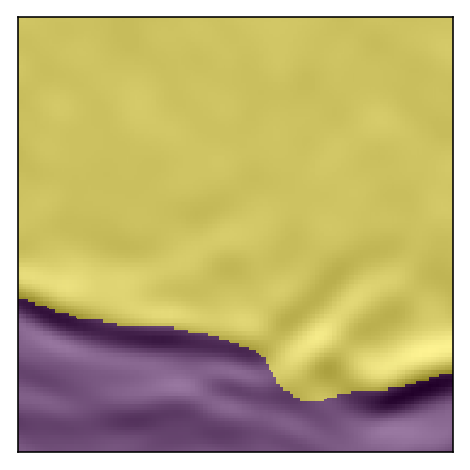

In [68]:
learn.load(best_models[0][0])
denorm = md.trn_ds.denorm
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))
ax = show_img(denorm(x)[1])
show_img(py[1]>0, ax=ax, alpha=0.5);

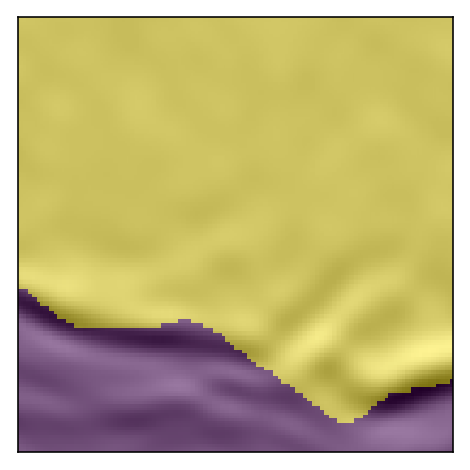

In [70]:
ax = show_img(denorm(x)[1])
show_img(y[1].cpu(), ax=ax, alpha=0.5);

In [71]:
m.close()

## Single Fold Validation Predictions

In [71]:
class TestFilesDataset(FilesDataset):
    def __init__(self,fnames,y,transform,flip,path):
        self.y = y
        self.flip = flip
        super().__init__(fnames,transform,path)
        
    def get_x(self,i):
        im = open_image(os.path.join(self.path,self.fnames[i]))
        return np.fliplr(im) if self.flip else im
    
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    
    def get_c(self): return 0

In [69]:
N_SNAPSHOTS = 6

In [161]:
sz=256
bs=10

val_preds = np.zeros(shape=(800,sz,sz))
targs = np.zeros(shape=(800,sz,sz))
for i in tqdm_notebook(range(N_SNAPSHOTS)):
    for o in [True,False]:
        tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
        datasets = ImageData.get_ds(TestFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, test=(tst_x, tst_x), flip=o, path=PATH)
        md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
        m_base = nn.Sequential(*list(children(ARCH))[:cut])
        m = to_gpu(UnetSEResNext50(m_base))
        models = UnetModel(m)
        learn = ConvLearner(md, models)
        learn.opt_fn = optim.Adam
        learn.metrics=[mean_avg_precision_IOU]
        learn.load(best_models[i][0])
        learn.model.eval()

        preds, targs = learn.predict_with_targs(is_test=False)
        for im_idx, im in enumerate(preds):
            val_preds[im_idx] += np.fliplr(im) if o else im
        del preds


In [162]:
val_preds.shape

(800, 256, 256)

In [163]:
val_preds = val_preds/(N_SNAPSHOTS*2)

In [164]:
# Find best IOU threshold
scores = []
thresh = []
for i in tqdm_notebook(range(-40,41,1)):
    t = i/100
    thresh.append(t)
    scores.append(mean_avg_precision_IOU(val_preds, targs, t))

In [165]:
thresholds = pd.DataFrame({'Thresholds': thresh, 'IOU Scores': scores})

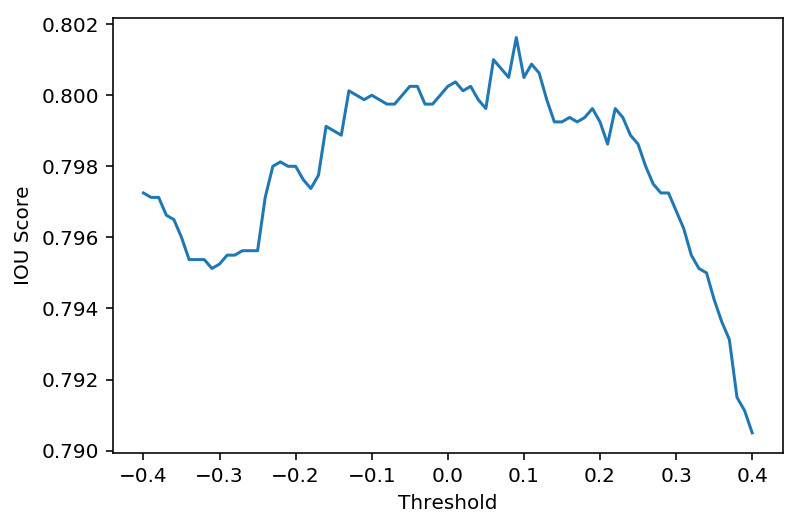

In [166]:
thresholds = thresholds.set_index('Thresholds')
plt.xlabel('Threshold')
plt.ylabel('IOU Score')
plt.plot(thresholds);

In [167]:
best_t = thresholds['IOU Scores'].argmax()
val_iou_score = mean_avg_precision_IOU(val_preds, targs, best_t)
display(val_iou_score)

0.8016249999999999

In [168]:
best_t

0.09

* 1 snapshot: 0.7955000
* 2 snapshot: 0.7976250
* 3 snapshot: 0.7988749
* 4 snapshot: 0.7991250
* 5 snapshot: 0.7994999
* **6 snapshot: 0.8016249**
* 7 snapshot: 0.8008750
* 8 snapshot: 0.8016250
* 9 snapshot: 0.8007499
* 10 snapshot: 0.800625

## Generate Test Predictions Using Single Fold Weights


In [65]:
best_models = [('unet_se_resnext50_single_fold_snapshot_1', 0.7909999999999999),
 ('unet_se_resnext50_single_fold_snapshot_2', 0.79025),
 ('unet_se_resnext50_single_fold_snapshot_3', 0.7895),
 ('unet_se_resnext50_single_fold_snapshot_4', 0.789125),
 ('unet_se_resnext50_single_fold_snapshot_5', 0.788375),
 ('unet_se_resnext50_single_fold_snapshot_6', 0.7880000000000001),
 ('unet_se_resnext50_single_fold_snapshot_7', 0.787875),
 ('unet_se_resnext50_single_fold_snapshot_8', 0.7873749999999998),
 ('unet_se_resnext50_single_fold_snapshot_9', 0.78625),
 ('unet_se_resnext50_single_fold_snapshot_10', 0.7853749999999999)]

best_t = 0.09

In [66]:
sz=256
bs=10

In [67]:
tst_preds = np.zeros(shape=(18000,sz,sz))

In [72]:
for i in tqdm_notebook(range(4)):
    for o in [True,False]:
        for j in range(N_SNAPSHOTS):
            tst_batch = tst_x[i*4500: (i+1)*4500] # Have to split into smaller batches to conserve memory
            tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
            datasets = ImageData.get_ds(TestFilesDataset, trn=(trn_x, trn_y), val=(val_x, val_y), tfms=tfms, test=(tst_batch,tst_batch), flip=o, path=PATH)
            md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
            m_base = nn.Sequential(*list(children(ARCH))[:cut])
            m = to_gpu(UnetSEResNext50(m_base))
            models = UnetModel(m)
            learn = ConvLearner(md, models)
            learn.opt_fn = optim.Adam
            learn.metrics=[mean_avg_precision_IOU]

            learn = ConvLearner(md, models)
            learn.opt_fn = optim.Adam
            learn.metrics=[mean_avg_precision_IOU]

            learn.load(best_models[j][0])
            learn.model.eval()
            preds = learn.predict(is_test=True)
            for im_idx, im in enumerate(preds):
                tst_preds[im_idx + (i*4500)] += np.fliplr(im) if o else im
            del preds

In [73]:
tst_preds.shape

(18000, 256, 256)

In [74]:
# Take the avg of TTA (flipped) and non-TTA preds
tst_preds = tst_preds/(N_SNAPSHOTS*2)

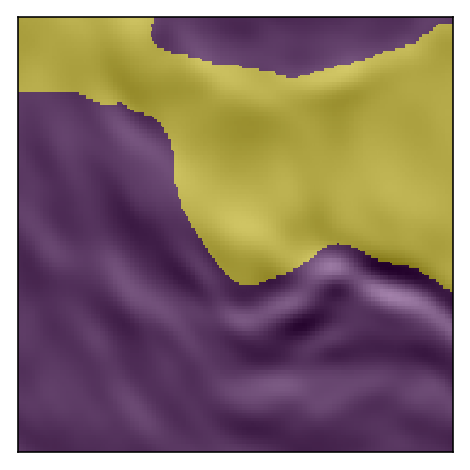

In [75]:
ax = show_img(scale_min(open_image(PATH/test_df.iloc[4]['im_path']), 256))
show_img(tst_preds[4]>best_t, ax=ax, alpha=0.5);

In [76]:
resized_tst_preds = []
for i, im in tqdm_notebook(enumerate(tst_preds),total=18000):
    resized = scale_min(im, 101)
    resized_tst_preds.append(resized)
resized_tst_preds = np.array(resized_tst_preds)

In [77]:
resized_tst_preds.shape

(18000, 101, 101)

In [78]:
resized_tst_preds[4]

array([[ 1.06167,  1.08638,  1.0941 , ..., -0.01212, -0.08738, -0.07217],
       [ 1.08706,  1.10574,  1.11434, ...,  0.06851,  0.01171,  0.02932],
       [ 1.09131,  1.10803,  1.11296, ...,  0.30271,  0.26318,  0.2838 ],
       ...,
       [-1.09593, -1.10207, -1.0702 , ..., -1.0963 , -1.12037, -1.18033],
       [-1.0958 , -1.13841, -1.10552, ..., -1.1322 , -1.16481, -1.18329],
       [-0.96549, -1.13733, -1.12311, ..., -1.20256, -1.22146, -1.08655]])

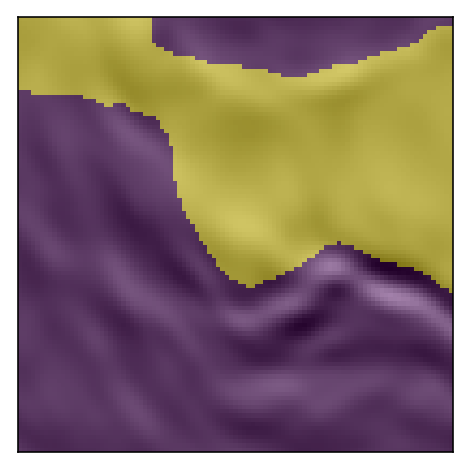

In [79]:
ax = show_img(open_image(PATH/test_df.iloc[4]['im_path']))
show_img(resized_tst_preds[4]>best_t, ax=ax, alpha=0.5);

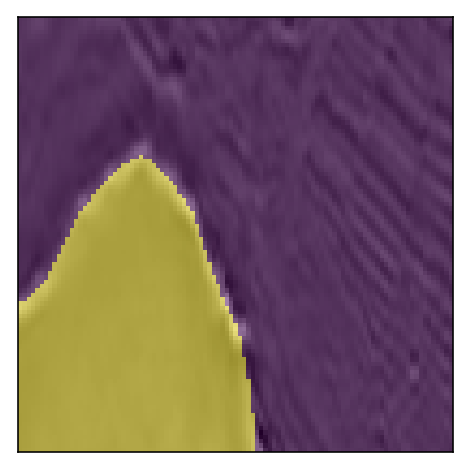

In [80]:
ax = show_img(open_image(PATH/test_df.iloc[17981]['im_path']))
show_img(resized_tst_preds[17981]>best_t, ax=ax, alpha=0.5);

In [81]:
# Courtesy of Tadeusz Hupało
# https://www.kaggle.com/thupalo
def rle(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    rle = ' '.join([str(r) for r in run_lengths])
    return rle

In [82]:
rle(resized_tst_preds[4]>best_t)

'1 17 102 17 203 17 304 18 405 18 506 18 607 18 708 18 809 18 910 18 1011 18 1112 18 1213 18 1314 18 1415 18 1516 19 1617 19 1718 19 1819 20 1920 20 2021 21 2122 21 2223 20 2324 20 2425 20 2526 21 2627 22 2728 22 2829 22 2930 23 3031 23 3138 17 3240 17 3341 19 3443 19 3544 22 3646 29 3747 33 3848 36 3949 38 4050 39 4152 40 4253 42 4354 43 4456 44 4557 45 4658 47 4759 48 4860 49 4961 50 5062 50 5163 51 5265 50 5366 51 5467 51 5568 50 5669 50 5770 49 5872 48 5973 48 6074 47 6176 46 6277 45 6378 45 6479 44 6580 44 6681 43 6781 43 6882 43 6983 42 7083 42 7184 41 7285 41 7385 42 7486 41 7587 42 7688 42 7789 42 7890 43 7990 44 8091 45 8191 46 8292 47 8393 47 8493 49 8594 49 8695 49 8796 49 8896 51 8997 51 9098 51 9198 52 9299 53 9399 54 9499 56 9599 57 9700 58 9800 60 9901 61 10002 61 10103 62'

In [83]:
df = pd.DataFrame(test_df.index)

In [84]:
rles = []

for i,im in tqdm_notebook(enumerate(resized_tst_preds),total=18000): rles.append(rle(im>best_t))

In [85]:
df['rle_mask'] = rles

In [86]:
df

,id,rle_mask
0,353e010b7b,
1,5439dbbddf,
2,71bab9f311,
3,52551f7a80,
4,512d8d9997,1 17 102 17 203 17 304 18 405 18 506 18 607 18...
5,64dba827d6,
6,0a3a8a5f37,
7,329563756f,1 4443 4445 99 4546 99 4647 99 4748 98 4849 98...
8,f6cba2e890,
9,989c646373,


In [87]:
SUBM = Path('subm/')
os.makedirs(SUBM, exist_ok=True)

In [88]:
fn = 'subm6_unet_seresnext50_single_fold'

In [89]:
df.to_csv(SUBM/f'{fn}.gz', compression='gzip', index=False)

In [90]:
FileLink(SUBM/f'{fn}.gz')

/home/paperspace/fastai/kaggle_tgs_salt_identification_challenge_competition/subm/subm6_unet_seresnext50_single_fold.gz

## N-Fold CV

### Create N-fold depth-stratified splits

In [65]:
train_df.sort_values('z', inplace=True)

In [66]:
N_FOLDS = 5
depths = train_df['z']
# Borrowed from n01z3 at https://www.kaggle.com/drn01z3/create-k-fold-splits-depths-stratified
train_df['fold'] = (list(range(N_FOLDS))*depths.shape[0])[:depths.shape[0]]

In [67]:
f_one = train_df[train_df['fold'] == 0]
f_two = train_df[train_df['fold'] == 1]
f_three = train_df[train_df['fold'] == 2]
f_four = train_df[train_df['fold'] == 3]
f_five = train_df[train_df['fold'] == 4]

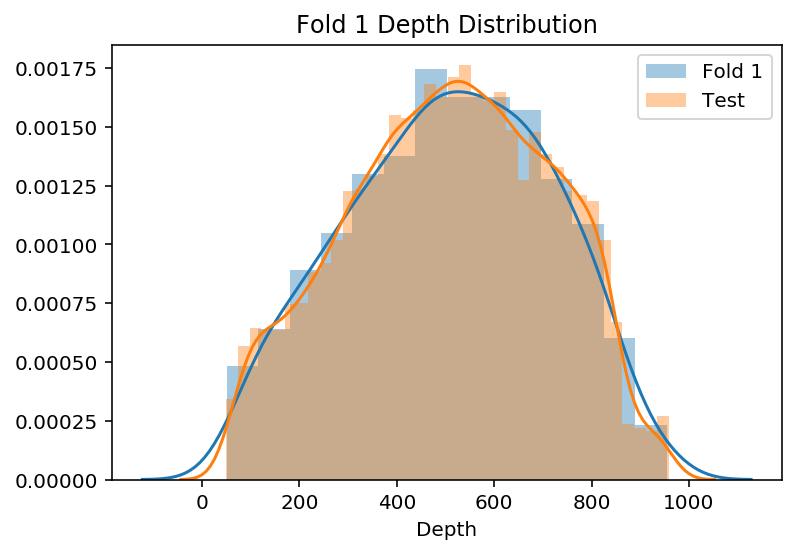

In [68]:
sns.distplot(f_one['z'], label="Fold 1")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 1 Depth Distribution");

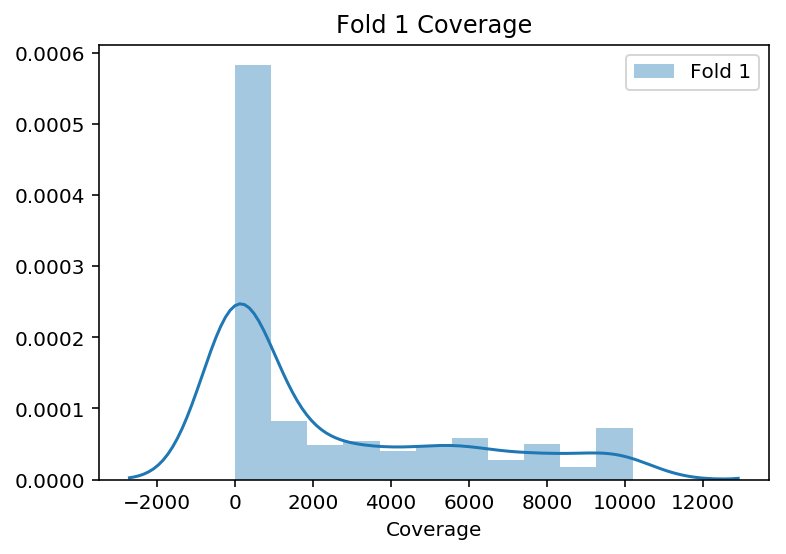

In [69]:
sns.distplot(f_one['cov'], label="Fold 1");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 1 Coverage");

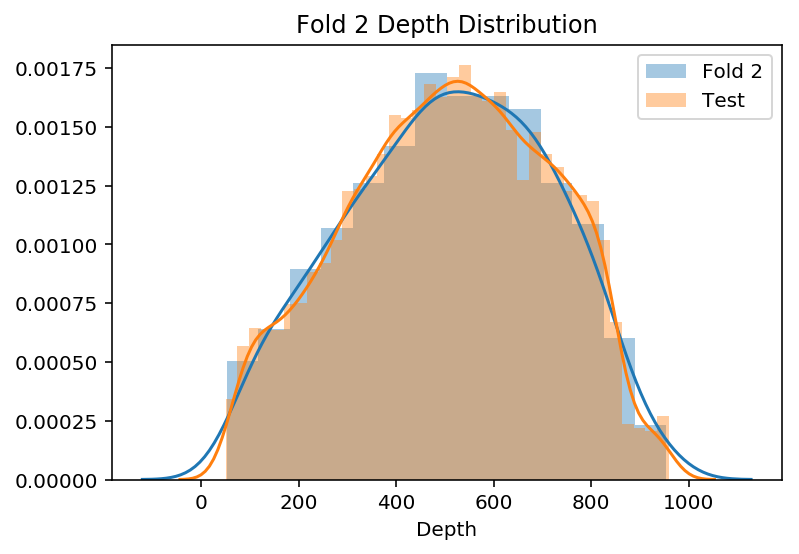

In [70]:
sns.distplot(f_two['z'], label="Fold 2")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 2 Depth Distribution");

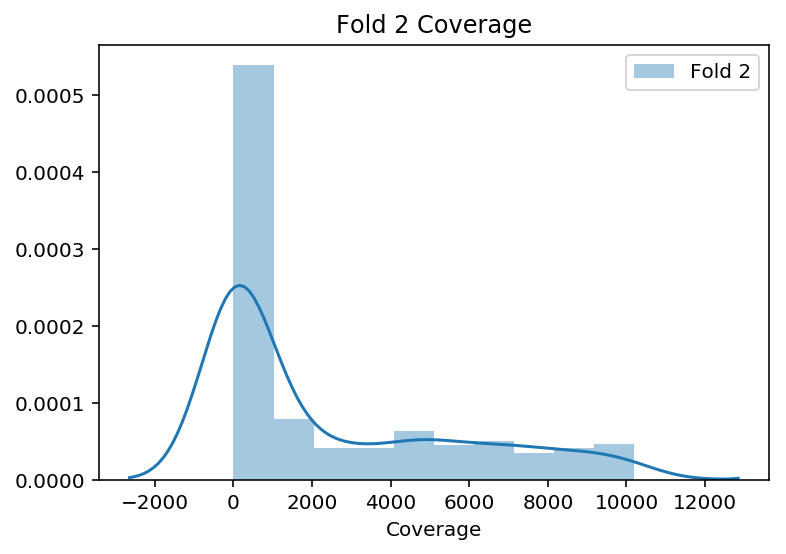

In [71]:
sns.distplot(f_two['cov'], label="Fold 2");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 2 Coverage");

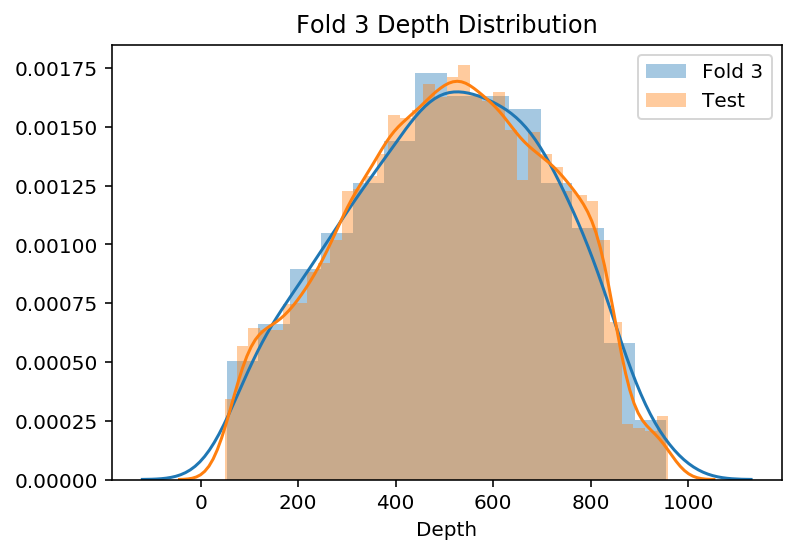

In [72]:
sns.distplot(f_three['z'], label="Fold 3")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 3 Depth Distribution");

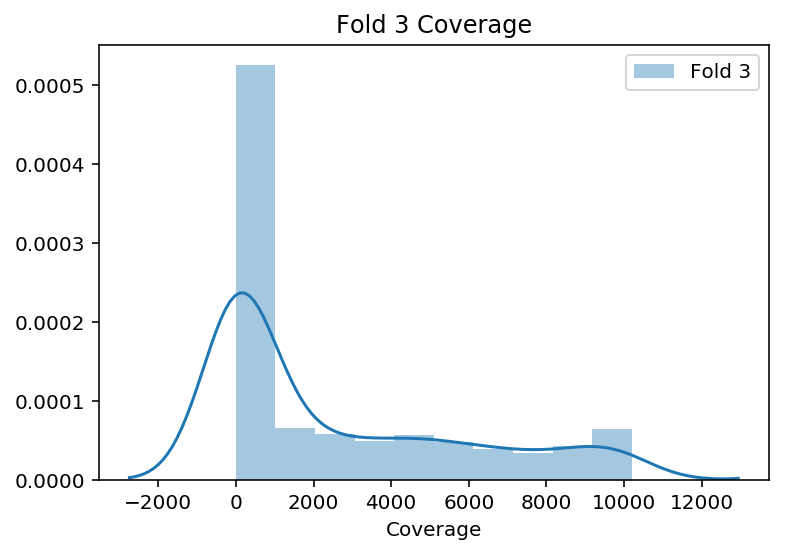

In [73]:
sns.distplot(f_three['cov'], label="Fold 3");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 3 Coverage");

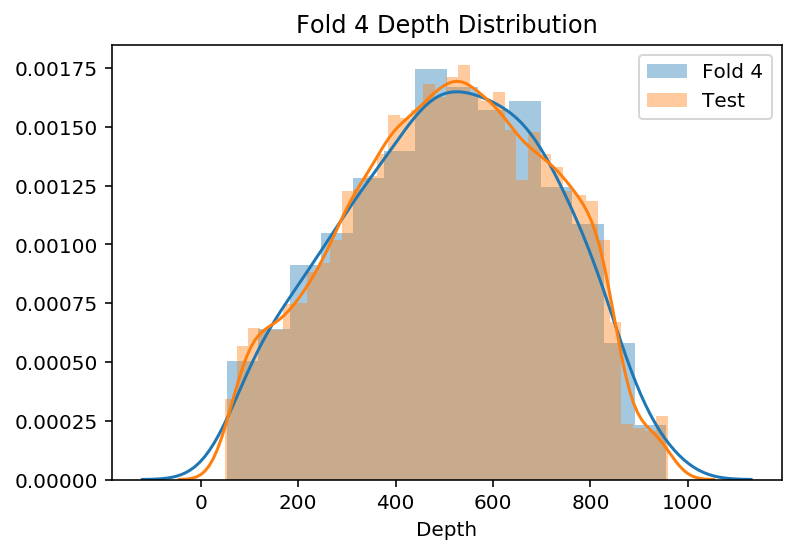

In [74]:
sns.distplot(f_four['z'], label="Fold 4")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 4 Depth Distribution");

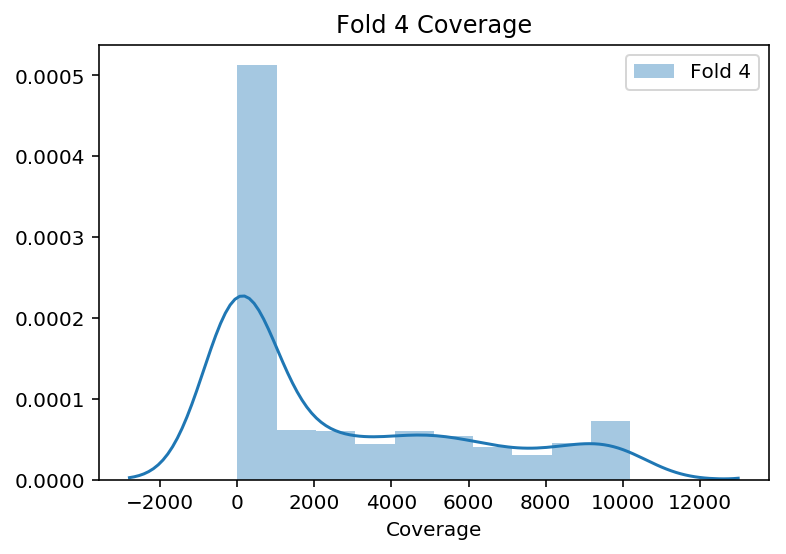

In [75]:
sns.distplot(f_four['cov'], label="Fold 4");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 4 Coverage");

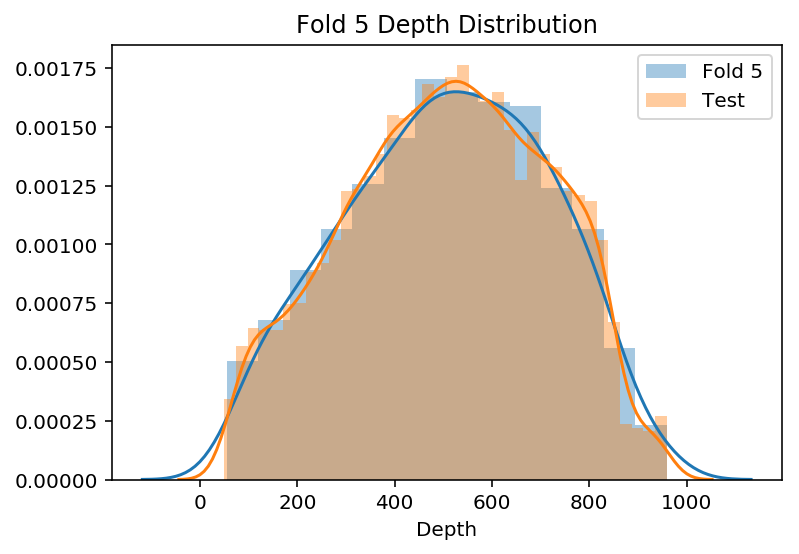

In [76]:
sns.distplot(f_five['z'], label="Fold 5")
sns.distplot(test_df['z'], label="Test")
plt.legend()
plt.xlabel('Depth')
plt.title("Fold 5 Depth Distribution");

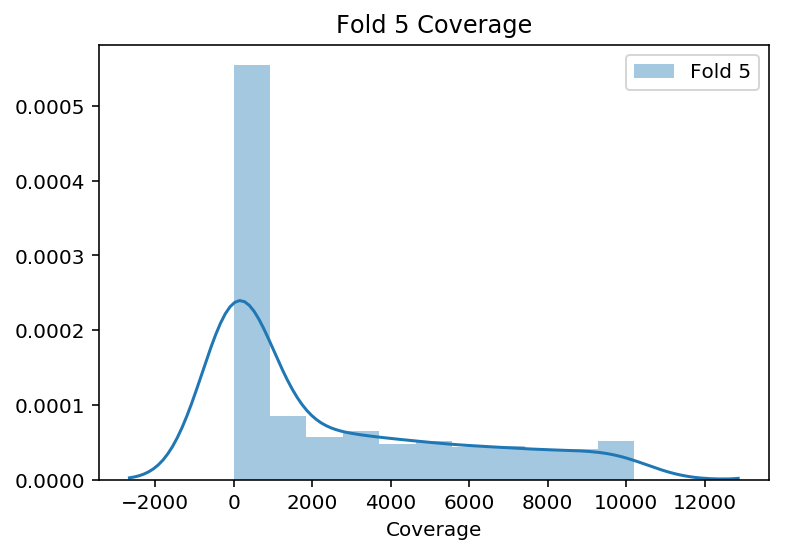

In [77]:
sns.distplot(f_five['cov'], label="Fold 5");
plt.legend()
plt.xlabel('Coverage')
plt.title("Fold 5 Coverage");

### Progressive Scaling Training

In [78]:
def train_64(train, val, arch):
    sz=64
    bs=80
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = nn.Sequential(*list(children(ARCH))[:-2])
    m = to_gpu(UnetSEResNext50(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5, 5, 10, 20
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp0')
    learn.load('64-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp1')
    learn.load('64-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp2')
    learn.load('64-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='64-tmp-final')

In [79]:
def train_128(train, val, arch):
    sz=128
    bs=50
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = nn.Sequential(*list(children(ARCH))[:-2])
    m = to_gpu(UnetSEResNext50(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5, 5, 10, 20
    learn.load('64-tmp-final')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp0')
    learn.load('128-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp1')
    learn.load('128-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp2')
    learn.load('128-tmp2')
    learn.crit=lovasz_loss
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=20,use_clr=(20,30,0.95,0.85),best_save_name='128-tmp-final')

In [80]:
def train_256(train, val, arch, n_fold, name, n_snapshots, snapshots_dir, n_runs):
    sz=256
    bs=20
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    lr=1e-2
    wd=1e-2
    lrs = np.array([lr/9,lr/3,lr])

    datasets = ImageData.get_ds(MatchedFilesDataset, train, val, tfms, test=(tst_x, tst_x), path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
    m_base = nn.Sequential(*list(children(ARCH))[:-2])
    m = to_gpu(UnetSEResNext50(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn = optim.Adam
    learn.metrics=[mean_avg_precision_IOU]
    # Cycle Lengths: 5,5,10,30
    learn.load('128-tmp-final')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.freeze_to(1)
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp0')
    learn.load('256-tmp0')
    learn.crit=lovasz_loss
    learn.fit(lr,1,wds=wd,use_wd_sched=True,cycle_len=5,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp1')
    learn.load('256-tmp1')
    learn.crit=nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.bn_freeze(False)
    learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=10,use_clr=(20,30,0.95,0.85),best_save_name='256-tmp2')

    # N-Run training for final training cycle. Use SaveTopNModels() class
    # to get top 5 models across both runs combined.
    best_models = []
    for i in range(n_runs):
        learn.load('256-tmp2')
        learn.crit=lovasz_loss
        learn.unfreeze()
        learn.bn_freeze(False)
        save_best_n = SaveTopNModels(learn, lrs, name, n_fold, snapshots_dir, n_saved=n_snapshots, run=i+1, final_run=(i==n_runs-1),best_models=best_models)
        learn.fit(lrs,1,wds=wd,use_wd_sched=True,cycle_len=30,use_clr=(20,30,0.95,0.85),callbacks=[save_best_n])
        best_models = save_best_n.best_models

    return learn, best_models

### N-Fold Validation Predictions

In [81]:
# From Vishnu: 
# https://github.com/svishnu88/TGS-SaltIdentification-Open-Solution-fastai/blob/master/Unet-Resnet34-Open%20Solution-FastAI.ipynb

class TestFilesDataset(FilesDataset):
    def __init__(self,fnames,y,transform,flip,path):
        self.y = y
        self.flip = flip
        super().__init__(fnames,transform,path)
        
    def get_x(self,i):
        im = open_image(os.path.join(self.path,self.fnames[i]))
        return np.fliplr(im) if self.flip else im
    
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    
    def get_c(self): return 0

In [82]:
def get_val_preds(train, val, arch, fold_models, n_snapshots, snapshots_path):
    sz=256
    bs=10
    val_preds = np.zeros(shape=(800,sz,sz))
    targs = np.zeros(shape=(800,sz,sz))
    for i in range(n_snapshots):
        model = fold_models[i]
        for o in [True,False]:   # TTA and Null
            tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
            datasets = ImageData.get_ds(TestFilesDataset, train, val, tfms, test=(tst_x, tst_x), flip=o, path=PATH)
            md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)
            m_base = nn.Sequential(*list(children(ARCH))[:-2])
            m = to_gpu(UnetSEResNext50(m_base))
            models = UnetModel(m)
            learn = ConvLearner(md, models)
            learn.opt_fn = optim.Adam
            learn.crit=nn.BCEWithLogitsLoss()
            learn.metrics=[mean_avg_precision_IOU]
            learn.load(snapshots_path/model[0])
            learn.model.eval()

            preds, targs = learn.predict_with_targs(is_test=False)
            for im_idx, im in enumerate(preds):
                val_preds[im_idx] += np.fliplr(im) if o else im
            del preds
    # Divide val_preds by 2 to get avg of TTA, Null preds
    # Also divide by number of snapshots
    return val_preds/(n_snapshots*2), targs  

In [83]:
def get_final_val_score(preds, targs, thresh):
    scores = []
    for i in tqdm_notebook(range(len(preds))):
        scores.append(mean_avg_precision_IOU(preds[i], targs[i], thresh))
    return np.mean(scores)

In [84]:
def get_best_thresh(preds, targs):
    scores = []
    thresh = []
    for i in range(-50,51,1):
        t = i/100
        thresh.append(t)
        scores.append(mean_avg_precision_IOU(preds, targs, t))
    return thresh[np.argmax(scores)]

### N-Fold Training Loop

In [ ]:
pipeline_strt = time.time()  # Start of training

In [ ]:
# N run (Take best n best snapshot across n runs)

# Callback - get N best models
# Inspired by Ismael Kone's SaveBestModel() class:
# http://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066
from operator import itemgetter

class SaveTopNModels(LossRecorder):
    def __init__(self, learn, lr, name, fold, snapshots_dir, n_saved=2, run=1,final_run=False,best_models=[]):
        super().__init__(learn.get_layer_opt(lr,None))
        self.learn = learn
        self.name = name
        self.fold = fold
        self.snapshots_dir = snapshots_dir
        self.n_saved = n_saved
        self.run = run
        self.final_run = final_run
        self.best_models = best_models
        self.epoch_cnt = 0
        
    def on_epoch_end(self,metrics):
        super().on_epoch_end(metrics)
        iou_score = metrics[1]
        model_name = self.name + f'_fold_{self.fold}_run_{self.run}_epoch_{self.epoch_cnt}'
        if self.epoch_cnt>0 or len(self.best_models)>0: worst_score = min(self.best_models, key=itemgetter(1))[1]
        if len(self.best_models) < self.n_saved:  
            self.best_models.append((model_name,iou_score))
            self.learn.save(self.snapshots_dir/model_name)
        elif iou_score > worst_score:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            name_to_del = self.best_models[-1][0]
            del self.best_models[-1]
            os.remove(PATH/MODELS/self.snapshots_dir/f'{name_to_del}.h5')
            self.best_models.append((model_name,iou_score))
            self.learn.save(self.snapshots_dir/model_name)
        self.epoch_cnt += 1
    
    def on_train_end(self):
        if self.final_run:
            self.best_models = sorted(self.best_models,key=itemgetter(1),reverse=True)
            print(self.best_models)
            for i, item in enumerate(self.best_models):
                new_name = self.name + f'_fold_{self.fold}_snapshot_{i+1}'
                print(f'{item[0]}.h5')
                print(new_name)
                os.rename(PATH/MODELS/self.snapshots_dir/f'{item[0]}.h5', PATH/MODELS/self.snapshots_dir/f'{new_name}.h5')
                self.best_models[i] = (new_name, item[1])

In [ ]:
N_FOLDS = 5
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [ ]:
N_SNAPSHOTS = 6
SNAPSHOTS = Path('unet_seresnext50/')
os.makedirs(PATH/MODELS/SNAPSHOTS, exist_ok=True)

In [ ]:
ARCH = se_resnext50_32x4d()
cut = -2 # where to cut the head of the model (which will be replaced with a custom head)
lr_cut = 2 # where to split the rest of the model into middle and tail groups

In [ ]:
all_models = []

for i in range(N_FOLDS):
    trn = train_df[train_df['fold'] != i]
    val = train_df[train_df['fold'] == i]
    trn_x = np.array(trn['im_path'])
    trn_y = np.array(trn['msk_path'])
    val_x = np.array(val['im_path'])
    val_y = np.array(val['msk_path'])
    ######
    print(f'############################################################################################')
    print(f'################################### Starting Fold {i+1} of {N_FOLDS} ###################################')
    print(f'############################################################################################\r')
    print('\r')
    ###### ######
    print(f'############ Size 64 ############ Now Training Fold {i+1} of {N_FOLDS} ############ Size 64 ############')
    train_64((trn_x,trn_y), (val_x,val_y), ARCH)
    print('\r')
    print('\r')
    print(f'############ Size 128 ########### Now Training Fold {i+1} of {N_FOLDS} ########### Size 128 ############')
    train_128((trn_x,trn_y), (val_x,val_y), ARCH)
    print('\r')
    print('\r')
    print(f'############ Size 256 ########### Now Training Fold {i+1} of {N_FOLDS} ########### Size 256 ############')
    learn, top_models = train_256((trn_x,trn_y), (val_x,val_y), ARCH, i+1, MODEL_NAME, N_SNAPSHOTS, SNAPSHOTS, 2)
    all_models.append(top_models)
    print('\r')
    print('\r')

In [ ]:
all_models

In [ ]:
N_SNAPSHOTS = 4

In [ ]:
# Make val predictions on each fold.
val_preds = []
val_targs = []
for i in tqdm_notebook(range(N_FOLDS)):
    fold_models = all_models[i]
    trn = train_df[train_df['fold'] != i]
    val = train_df[train_df['fold'] == i]
    trn_x = np.array(trn['im_path'])
    trn_y = np.array(trn['msk_path'])
    val_x = np.array(val['im_path'])
    val_y = np.array(val['msk_path'])
    preds, targs = get_val_preds((trn_x,trn_y), (val_x,val_y), ARCH, fold_models, N_SNAPSHOTS, SNAPSHOTS)
    val_preds.append(preds)
    val_targs.append(targs)
    del preds, targs

In [ ]:
best_thresh = []
print('Calculating Best Avg Threshold:')
for i in tqdm_notebook(range(len(val_preds))):
    best_thresh.append(get_best_thresh(val_preds[i], val_targs[i]))
    
avg_best_thresh = np.mean(best_thresh)
print('----------------------------------------------------------------------')
print(f'Avg Best IOU Threshhold Across All {N_FOLDS} Folds is: {avg_best_thresh}')
print('----------------------------------------------------------------------')
print('\r')
print('Calculating Avg Val Score:')
final_val_score = get_final_val_score(val_preds, val_targs, avg_best_thresh)
print('----------------------------------------------------------------------')
print(f'Avg Validation IOU Score Across All {N_FOLDS} Folds is: {final_val_score}')
print('----------------------------------------------------------------------')

## Generate Test Predictions Using 5 Fold Weights

In [ ]:
sz=256
bs=10

tst_preds = np.zeros(shape=(18000,sz,sz))

In [ ]:
N_SNAPSHOTS = 4
avg_best_thresh = 

In [ ]:
for i in tqdm_notebook(range(10)):
    for o in [True,False]:
        for k in range(N_FOLDS):
            fold_models = all_models[k]
            for j in range(N_SNAPSHOTS):
                tst_batch = tst_x[i*1800: (i+1)*1800] # Have to split into smaller batches to conserve memory
                tfms = tfms_from_model(ARCH, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
                datasets = ImageData.get_ds(TestFilesDataset, trn=(trn_x, trn_y), val=(val_x, val_y), tfms=tfms, test=(tst_batch,tst_batch), flip=o, path=PATH)
                m_base = nn.Sequential(*list(children(ARCH))[:-2])
                m = to_gpu(UnetSEResNext50(m_base))
                models = UnetModel(m)
                learn = ConvLearner(md, models)
                learn.opt_fn = optim.Adam
                learn.metrics=[mean_avg_precision_IOU]
                learn.load(SNAPSHOTS/fold_models[j][0])
                learn.model.eval()
                preds = learn.predict(is_test=True)
                for im_idx, im in enumerate(preds):
                    tst_preds[im_idx + (i*1800)] += np.fliplr(im) if o else im
                del preds

In [ ]:
tst_preds.shape

In [ ]:
# Take the avg of TTA (flipped) and non-TTA preds, across all snapshots of all folds
tst_preds = tst_preds/(N_FOLDS*N_SNAPSHOTS*2)

In [ ]:
ax = show_img(scale_min(open_image(PATH/test_df.iloc[4]['im_path']), 256))
show_img(tst_preds[4]>avg_best_thresh, ax=ax, alpha=0.5);

In [ ]:
resized_tst_preds = []
for i, im in tqdm_notebook(enumerate(tst_preds),total=18000):
    resized = scale_min(im, 101)
    resized_tst_preds.append(resized)
resized_tst_preds = np.array(resized_tst_preds)

In [ ]:
resized_tst_preds.shape

In [ ]:
resized_tst_preds[4]

In [ ]:
ax = show_img(open_image(PATH/test_df.iloc[4]['im_path']))
show_img(resized_tst_preds[4]>avg_best_thresh, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(open_image(PATH/test_df.iloc[17981]['im_path']))
show_img(resized_tst_preds[17981]>avg_best_thresh, ax=ax, alpha=0.5);

In [ ]:
# Courtesy of Tadeusz Hupało
# https://www.kaggle.com/thupalo
def rle(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    rle = ' '.join([str(r) for r in run_lengths])
    return rle

In [ ]:
rle(resized_tst_preds[4]>avg_best_thresh)

In [ ]:
df = pd.DataFrame(test_df.index)

In [ ]:
rles = []

for i,im in tqdm_notebook(enumerate(resized_tst_preds),total=18000): rles.append(rle(im>avg_best_thresh))

In [ ]:
df['rle_mask'] = rles

In [ ]:
df

In [ ]:
dur = time.time() - pipeline_strt
hrs = dur//3600
mins = (dur-hrs*3600)//60
sec = round((dur-hrs*3600-mins*60))
print(f'5-Fold Train Predict Pipeline Completed in {hrs} hrs {mins} mins {sec} sec')  # Total training/pred duration

### Make Submission

In [ ]:
SUBM = Path('subm/')
os.makedirs(SUBM, exist_ok=True)

In [ ]:
fn = 'subm6_unet_seresnext50_single_fold'

In [ ]:
df.to_csv(SUBM/f'{fn}.gz', compression='gzip', index=False)

In [ ]:
FileLink(SUBM/f'{fn}.gz')